# Bayesian Estimation Supersedes the T-Test

This model replicates the example used in:
Kruschke, John. (2012) **Bayesian estimation supersedes the t-test**. *Journal of Experimental Psychology*: General.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by Thomas Wiecki (c) 2015, update by Chris Fonnesbeck.

### The Problem

Several statistical inference procedures involve the comparison of two groups. We may be interested in whether one group is larger than another, or simply different from the other. We require a statistical model for this because true differences are usually accompanied by measurement or stochastic noise that prevent us from drawing conclusions simply from differences calculated from the observed data. 

The *de facto* standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (*e.g.* statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999). 

A more informative and effective approach for comparing groups is one based on **estimation** rather than **testing**, and is driven by Bayesian probability rather than frequentist.

In [2]:
%matplotlib inline
import numpy as np
import pymc3 as pm

Data from two experimental arms

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

Create variables for model

In [4]:
y1 = np.array(drug)
y2 = np.array(placebo)
y = np.concatenate((y1, y2))

μ_m = np.mean( y )
μ_p = 1000 * np.std(y)

σ_low = np.std(y)/1000
σ_high = np.std(y)*1000

In [5]:
with pm.Model() as model:
    
    group1_mean = pm.Normal('group1_mean', μ_m, sd=μ_p)
    group2_mean = pm.Normal('group2_mean', μ_m, tau=μ_p)
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

Applied interval-transform to group1_std and added transformed group1_std_interval to model.
Applied interval-transform to group2_std and added transformed group2_std_interval to model.


In [6]:
with model:
    
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1
    
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

Applied log-transform to ν_minus_one and added transformed ν_minus_one_log to model.


In [7]:
with model:

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2) / 2))


In [8]:
with model:
    trace = pm.sample(2000)

Assigned NUTS to group1_mean
Assigned NUTS to group2_mean
Assigned NUTS to group1_std_interval
Assigned NUTS to group2_std_interval
Assigned NUTS to ν_minus_one_log
 [-----------------100%-----------------] 2000 of 2000 complete in 23461.1 sec

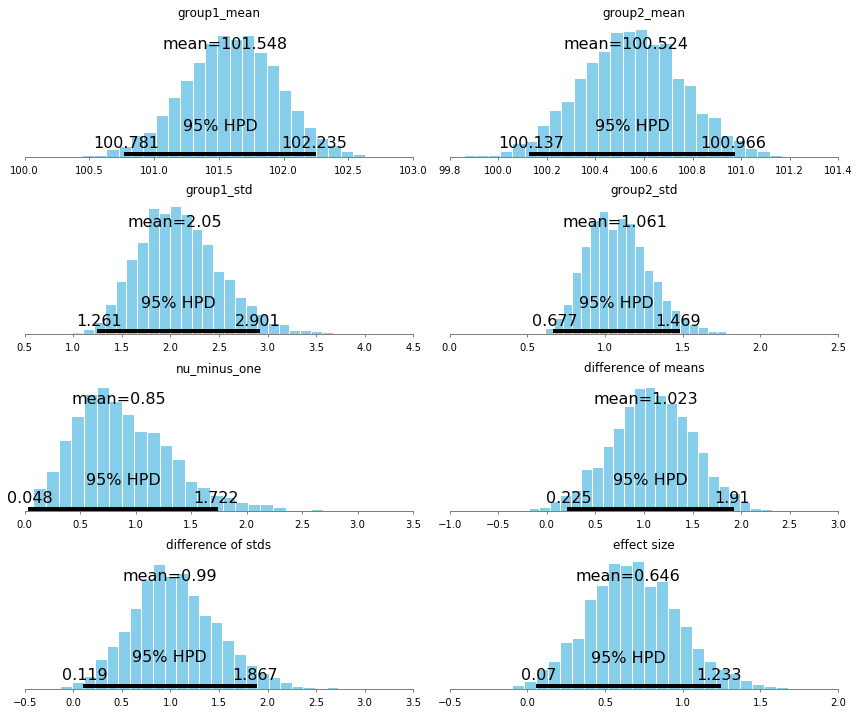

In [5]:
pm.plot_posterior(trace[1000:], color='#87ceeb');

In [6]:
pm.plots.summary(trace[1000:])


group1_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  101.548          0.369            0.005            [100.781, 102.235]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.796        101.303        101.555        101.801        102.260


group2_mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  100.524          0.213            0.003            [100.137, 100.966]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  100.111        100.379        100.525        100.668        100.944


group1_std:

  Mean             SD               MC Error         95% HPD interva

## References

1.	Goodman SN. Toward evidence-based medical statistics. 1: The P value fallacy. Annals of Internal Medicine. 1999;130(12):995-1004. doi:10.7326/0003-4819-130-12-199906150-00008.
2.	Johnson D. The insignificance of statistical significance testing. Journal of Wildlife Management. 1999;63(3):763-772.
3.	Kruschke JK. Bayesian estimation supersedes the t test. J Exp Psychol Gen. 2013;142(2):573-603. doi:10.1037/a0029146.